## Introduction
This project analyzes the intersection between 2024 wildfire perimeters in California and the Social Vulnerability Index (SVI) at the census tract level. The goal is to identify how much of the state’s high-vulnerability population was directly affected by wildfires, measured through burned area overlap and estimated exposed population.

In [1]:
# Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt

# Check layers of GDB files
print("California GDB layers:", gpd.io.file.fiona.listlayers("california.gdb"))
print("Fire241 GDB layers:", gpd.io.file.fiona.listlayers("fire241.gdb"))

California GDB layers: ['SVI2022_CALIFORNIA_tract']
Fire241 GDB layers: ['rxburn24_1', 'firep24_1']


In [2]:
# Load SVI tracts
svi = gpd.read_file("california.gdb", layer="SVI2022_CALIFORNIA_tract")

# Load wildfire perimeters (2024)
fires = gpd.read_file("fire241.gdb", layer="firep24_1")

In [3]:
# Reproject both to California Albers (EPSG:3310)
svi = svi.to_crs(3310)
fires = fires.to_crs(3310)

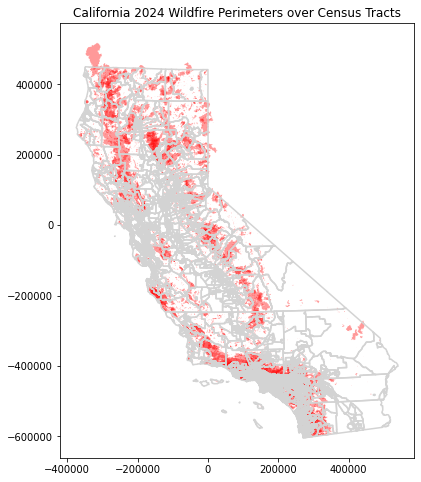

In [4]:
# Quick visual check (red polygons are fires, grey outlines are tracts)
fig, ax = plt.subplots(figsize=(8,8))
svi.boundary.plot(ax=ax, color="lightgrey")
fires.plot(ax=ax, color="red", alpha=0.4)
ax.set_title("California 2024 Wildfire Perimeters over Census Tracts")
plt.show()

In [5]:
# Compute each tract’s area before overlay
svi["tract_area_m2"] = svi.geometry.area

# Keep only necessary columns from SVI before overlay
svi_sub = svi[["FIPS", "E_TOTPOP", "RPL_THEMES", "tract_area_m2", "geometry"]]

# Perform intersection
impacted = gpd.overlay(svi_sub, fires[["YEAR_", "FIRE_NAME", "GIS_ACRES", "geometry"]], how="intersection")

# Compute the intersection (burned) area
impacted["burned_area_m2"] = impacted.geometry.area

# Fraction of tract burned
impacted["frac_burned"] = impacted["burned_area_m2"] / impacted["tract_area_m2"]

# Estimate exposed population
impacted["pop_exposed"] = impacted["E_TOTPOP"] * impacted["frac_burned"]

impacted.head(3)

FIPS  E_TOTPOP  RPL_THEMES  tract_area_m2   YEAR_ FIRE_NAME  \
0  06001400100      3269      0.1598   6.958089e+06  2024.0      PEAK   
1  06001400100      3269      0.1598   6.958089e+06  1991.0    TUNNEL   
2  06001400200      2147      0.1827   5.781346e+05  1991.0    TUNNEL   

     GIS_ACRES                                           geometry  \
0     0.378119  MULTIPOLYGON (((-195878.919 -12815.038, -19587...   
1  1622.755371  POLYGON ((-195081.994 -14399.559, -195146.466 ...   
2  1622.755371  POLYGON ((-197094.216 -15959.338, -196982.298 ...   

   burned_area_m2  frac_burned  pop_exposed  
0    1.530194e+03     0.000220     0.718905  
1    2.380512e+06     0.342122  1118.395336  
2    1.202064e+04     0.020792    44.640677

In [6]:
# Define high vulnerability (top 25%)
impacted['is_high_vuln'] = impacted['RPL_THEMES'] > 0.75

# Aggregate totals
exposure_summary = impacted.groupby('YEAR_').agg(
    total_pop_exposed=('pop_exposed', 'sum'),
    total_area_burned=('burned_area_m2', 'sum'),
    high_vuln_pop_exposed=('pop_exposed', lambda x: impacted.loc[x.index, 'pop_exposed'][impacted['is_high_vuln']].sum())
).reset_index()

# Convert to km²
exposure_summary['total_area_burned_km2'] = exposure_summary['total_area_burned'] / 1e6
exposure_summary['pct_high_vuln_pop'] = (
    100 * exposure_summary['high_vuln_pop_exposed'] / exposure_summary['total_pop_exposed']
)

exposure_summary[['YEAR_', 'total_pop_exposed', 'total_area_burned_km2', 'pct_high_vuln_pop']]

YEAR_  total_pop_exposed  total_area_burned_km2  pct_high_vuln_pop
0    1878.0       84153.378453             240.662029           1.695565
1    1895.0           2.098599               2.541886           0.000000
2    1896.0          25.164327              30.479777           0.000000
3    1898.0        1345.444217             114.300220           7.642484
4    1900.0       10390.181819              99.263344           0.000000
..      ...                ...                    ...                ...
123  2021.0       29398.185382           10105.360143           2.254307
124  2022.0       13577.607724            1304.272459           4.665608
125  2023.0        4523.268357            1298.677374           7.881557
126  2024.0       31536.882218            4071.141672           8.132923
127  2025.0       53158.525487             202.624605           0.000000

[128 rows x 4 columns]

/tmp/ipykernel_1519/1886679708.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  impact_2024 = gpd.overlay(impacted, fires_2024, how='intersection')


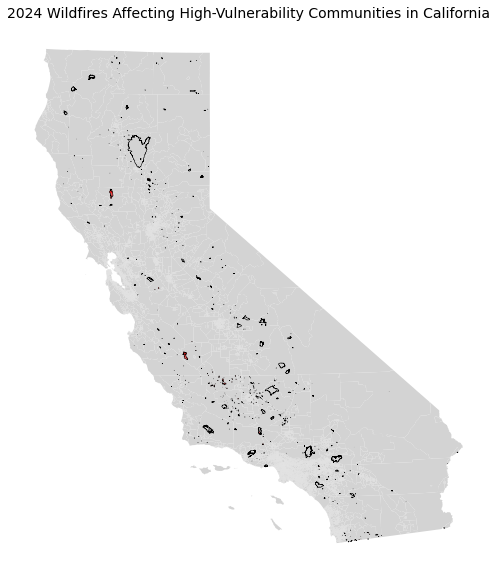

In [7]:
# Map of fires for 2024 and their impact on high-vulnerability communities in California. 
fires_2024 = fires[fires['YEAR_'] == 2024]
impact_2024 = gpd.overlay(impacted, fires_2024, how='intersection')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
svi.plot(ax=ax, color='lightgrey', linewidth=0.1)
impact_2024[impact_2024['is_high_vuln']].plot(ax=ax, color='red', alpha=0.6)
fires_2024.boundary.plot(ax=ax, color='black', linewidth=0.5)
ax.set_title("2024 Wildfires Affecting High-Vulnerability Communities in California", fontsize=14)
ax.set_axis_off()
plt.show()

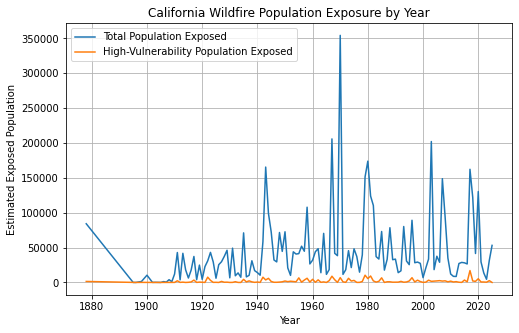

In [8]:
# Chart for comparing wildfire population exposures of total and high-vulnerability over the years
plt.figure(figsize=(8,5))
plt.plot(exposure_summary['YEAR_'], exposure_summary['total_pop_exposed'], label='Total Population Exposed')
plt.plot(exposure_summary['YEAR_'], exposure_summary['high_vuln_pop_exposed'], label='High-Vulnerability Population Exposed')
plt.xlabel('Year')
plt.ylabel('Estimated Exposed Population')
plt.title('California Wildfire Population Exposure by Year')
plt.legend()
plt.grid(True)
plt.show()

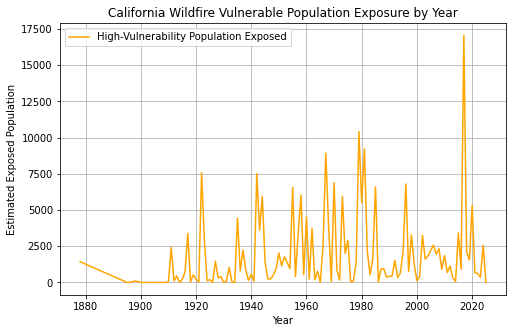

In [9]:
# Chart for wildfire population exposures of high-vulnerability areas over the years
plt.figure(figsize=(8,5))
plt.plot(exposure_summary['YEAR_'], exposure_summary['high_vuln_pop_exposed'], label='High-Vulnerability Population Exposed', color='orange')
plt.xlabel('Year')
plt.ylabel('Estimated Exposed Population')
plt.title('California Wildfire Vulnerable Population Exposure by Year')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion
The 2024 wildfire perimeters are overlapped with several socially vulnerable tracts across California. These high-risk tracts, represented in red on the map, highlight regions where populations may face greater challenges recovering from wildfire impacts due to socioeconomic and demographic factors. The analysis demonstrates how integrating CAL FIRE perimeter data with SVI can identify priority zones for disaster preparedness and recovery planning.